Задание выполнила Кордзахия Натела (БЭК181)

In [106]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import numpy.random
# Модули для визуализации
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import seaborn as sns
import plotly
import plotly.express as px
import scipy.stats as sts
plt.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm_notebook  

# Добро пожаловать в прекрасный мир данных, которые я использовала для своего курсача

### Так уж сложилось, что я решила делать большое исследование, связанное с кинематографом и Голливудом. Тема моей курсовой: "Голливуд как бренд: факторы, формирующие стоимость в современной киноиндустрии". В этой работе я анализировала различные данные, взятые с сайта  www.the-numbers.com, и один из датасетов, которые я делалаа, я хотела бы показать и вам.

# ИТАК НАЧНЕМ!

Поговорим о дистрибьютерах кинофильмов: чаще всего ими являются сами кинокомпании и их дочерние фирмы (например, у Дисней дочерные кинокомпании - это Марвел и ЛукасФильм). Так давайте скачаем те данные, которые предоставляет нам сайт  www.the-numbers.com для дистрибьютеров. 

Пам-пам -- вот и парсер (я не гений Питона поэтому тут циклы, зато все четенько и красиво в самом датасете)

In [107]:
def parser(year):
    url = 'https://www.the-numbers.com/market/{}/distributors'.format(year)
    res = requests.get(url)
    html = res.content
    tree = BeautifulSoup(html, 'html.parser')
    dists = tree.find_all('td')[3:]
    places = dists[::6]
    name = dists[1::6]
    movies = dists[2::6]
    gross = dists[3::6]
    tickets = dists[4::6]
    percent = dists[5::6]
    infa = []
    for i in range(len(places)):
        a = places[i].text.strip()
        b = name[i].text.strip()
        c = movies[i].text.strip()
        d = gross [i].text.strip()
        e = tickets[i].text.strip()
        g = percent[i].text.strip()
        infa.append({'Рейтинг': a,
                     'Компания':b,
                     'Кол-во фильмов': c,
                     'Box office': d,
                     'Кол-во билетов': e,
                     'Процент от общего кол-ва': g,
                     'Год': year})
    
    df = pd.DataFrame(infa)
    return df

Данный парсер скачивает табличку с сайта. Но нам для анализа понадобиться чуть больше табличек. Так давайте скачаем все за последние 25 лет (более ранних данных в сайте нет).

In [108]:
def pparser(begin, end):
    a = parser(begin)
    for year in tqdm_notebook(range(begin + 1, end, 1)):
        b = parser(year)
        res = pd.concat([a, b], ignore_index=True)
        a = res
    return a

In [109]:
df = pparser(1995, 2020)
df

,Рейтинг,Компания,Кол-во фильмов,Box office,Кол-во билетов,Процент от общего кол-ва,Год
0,1,Walt Disney,38,"$1,012,034,105","232,651,499",19.04%,1995
1,2,Warner Bros.,31,"$866,884,482","199,283,775",16.31%,1995
2,3,Sony Pictures,31,"$682,169,140","156,820,477",12.84%,1995
3,4,Universal,21,"$666,656,425","153,254,338",12.54%,1995
4,5,Paramount Pictures,21,"$529,884,404","121,812,497",9.97%,1995
...,...,...,...,...,...,...,...
2844,125,International Film Circuit,1,"$5,006",549,0.00%,2019
2845,126,Shout! Factory,1,"$4,332",475,0.00%,2019
2846,127,Sumbadhat Productions,1,"$3,919",430,0.00%,2019
2847,128,Producers Releasing Corporation,1,"$1,540",169,0.00%,2019


Уху, класс! Мы получили данные за 20 лет по всем дистрибьютерам, представленных на сайте. Но что же тут творится? Все не так-то просто, в датасете начиная с каждого нового года компании повторяются, и каждый год в табличке присутствуют разные компании. Исходя из всех тех длинных скучных выводов, которые я делала в своем курсаче, в таблице присутсвуют данные по Major 6 за каждый год. Что такое Major 6? Это 6 главных кинокомпании в мире, которые поставляют самое большое количество фильмов в год, обладают самыми большими бюджетами и получают самые большие кассовые сборы. Этими компаниями являются Universal Pictures, Paramount Pictures, Warner Bros. Pictures, Walt Disney Pictures, Columbia Pictures и 20th Century Studios (в марте прошлого года она стала часть Walt Disney, но пока что во всех датасетах представлена отдельно). Давайте проверим, как часто за период с 2000 по 2020 года встречаются все кинокомпании

In [110]:
df['Компания'].value_counts()[:20]

Sony Pictures             25
Universal                 25
Warner Bros.              25
Walt Disney               25
Strand                    25
Fox Searchlight           25
20th Century Fox          25
Sony Pictures Classics    25
Paramount Pictures        25
Lionsgate                 24
Zeitgeist                 23
First Run Features        23
IMAX Films                22
Rialto Pictures           21
MGM                       21
Eros Entertainment        20
Focus Features            20
Indican Pictures          20
New Yorker                19
IFC Films                 19
Name: Компания, dtype: int64

Что и требоваалось доказать

Для того, чтобы можно было хорошо работать с датасетом, необходимо проверить, какие значения в нем отсуствуют. Сделаем это через красивую функцию, которую я писала для дз2

In [111]:
def mis_val_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        table = pd.concat([mis_val, mis_val_percent], axis=1, 
                          keys=['Кол-во пропущенных значений','     % от общего количества'])
        return table[table.iloc[:,1] != 0]
print(mis_val_table(df))

Empty DataFrame
Columns: [Кол-во пропущенных значений,      % от общего количества]
Index: []


Так, неожидано, давайте еще по-другому

In [112]:
df.isnull().sum()

Рейтинг                     0
Компания                    0
Кол-во фильмов              0
Box office                  0
Кол-во билетов              0
Процент от общего кол-ва    0
Год                         0
dtype: int64

Какой милый датасет я спарсила, в нем нет пропусков! Но обработать я его все равно хочу. Я более чем уверена, что внутри лежат значения, которые достаточно маленькие и на общую картину не повляют. Давайте считать, что такие значения в этом таблице можно вычислить по проценту из общего количества и скажем, что компании, общий процент которых равен 0% вообще нам не нужны. 

In [113]:
df = df.loc[df['Процент от общего кол-ва'] != '0.00%']
df

,Рейтинг,Компания,Кол-во фильмов,Box office,Кол-во билетов,Процент от общего кол-ва,Год
0,1,Walt Disney,38,"$1,012,034,105","232,651,499",19.04%,1995
1,2,Warner Bros.,31,"$866,884,482","199,283,775",16.31%,1995
2,3,Sony Pictures,31,"$682,169,140","156,820,477",12.84%,1995
3,4,Universal,21,"$666,656,425","153,254,338",12.54%,1995
4,5,Paramount Pictures,21,"$529,884,404","121,812,497",9.97%,1995
...,...,...,...,...,...,...,...
2781,62,1091 Media,5,"$734,336","80,605",0.01%,2019
2782,63,ESX Entertainment,1,"$725,042","79,587",0.01%,2019
2783,64,Briarcliffe Entertainment,1,"$700,261","76,867",0.01%,2019
2784,65,Mongrel Media,1,"$650,565","71,412",0.01%,2019


Ого, количество строк в датасете уменьшилось вдвое.

Давайте придумаем какие-нибудь классные новые значения!

Например - среднюю количество посетителей фильмов разных компаниф каждый год. Просто возьмем и разделим кол-во билетов на кол-во фильмов
и поймем, на фильмы какой компании в среднем ходит больше людей

In [114]:
df[:10]

,Рейтинг,Компания,Кол-во фильмов,Box office,Кол-во билетов,Процент от общего кол-ва,Год
0,1,Walt Disney,38,"$1,012,034,105","232,651,499",19.04%,1995
1,2,Warner Bros.,31,"$866,884,482","199,283,775",16.31%,1995
2,3,Sony Pictures,31,"$682,169,140","156,820,477",12.84%,1995
3,4,Universal,21,"$666,656,425","153,254,338",12.54%,1995
4,5,Paramount Pictures,21,"$529,884,404","121,812,497",9.97%,1995
5,6,20th Century Fox,15,"$410,787,635","94,433,933",7.73%,1995
6,7,MGM,19,"$333,155,248","76,587,403",6.27%,1995
7,8,New Line,16,"$331,897,897","76,298,359",6.25%,1995
8,9,Miramax,38,"$186,292,656","42,825,880",3.51%,1995
9,10,Savoy,9,"$65,459,506","15,048,158",1.23%,1995


In [34]:
df['Среднее кол-во посетителей'] = df['Кол-во билетов']/df['Кол-во фильмов']
df

TypeError: unsupported operand type(s) for /: 'str' and 'str'

Неприятность случилась. Надо все починить! Я предугадываю проблему, что значения в таблице будут некрасивые, поэтому сделаем парочку манипуляци, чтобы все сразу было красиво!


In [115]:
a = pd.DataFrame(df)
a['Кол-во билетов'] = [x.replace(',', '') for x in a['Кол-во билетов']]
a['Кол-во билетов'] = a['Кол-во билетов'].astype(float)
a['Кол-во фильмов'] = a['Кол-во фильмов'].astype(float)

a['Среднее кол-во посетителей'] = a['Кол-во билетов']/a['Кол-во фильмов']
a

,Рейтинг,Компания,Кол-во фильмов,Box office,Кол-во билетов,Процент от общего кол-ва,Год,Среднее кол-во посетителей
0,1,Walt Disney,38.0,"$1,012,034,105",232651499.0,19.04%,1995,6.122408e+06
1,2,Warner Bros.,31.0,"$866,884,482",199283775.0,16.31%,1995,6.428509e+06
2,3,Sony Pictures,31.0,"$682,169,140",156820477.0,12.84%,1995,5.058725e+06
3,4,Universal,21.0,"$666,656,425",153254338.0,12.54%,1995,7.297826e+06
4,5,Paramount Pictures,21.0,"$529,884,404",121812497.0,9.97%,1995,5.800595e+06
...,...,...,...,...,...,...,...,...
2781,62,1091 Media,5.0,"$734,336",80605.0,0.01%,2019,1.612100e+04
2782,63,ESX Entertainment,1.0,"$725,042",79587.0,0.01%,2019,7.958700e+04
2783,64,Briarcliffe Entertainment,1.0,"$700,261",76867.0,0.01%,2019,7.686700e+04
2784,65,Mongrel Media,1.0,"$650,565",71412.0,0.01%,2019,7.141200e+04


Ух, давайте теперь узнем средний бюджет!

In [116]:
a['Box office'] = [x.replace(',', '') for x in a['Box office']]
a['Box office'] = [x.replace('$', '') for x in a['Box office']]
a['Box office'] = a['Box office'].astype(float)


a['Средний бюджет'] = a['Box office']/a['Кол-во фильмов']

In [117]:
a

,Рейтинг,Компания,Кол-во фильмов,Box office,Кол-во билетов,Процент от общего кол-ва,Год,Среднее кол-во посетителей,Средний бюджет
0,1,Walt Disney,38.0,1.012034e+09,232651499.0,19.04%,1995,6.122408e+06,2.663248e+07
1,2,Warner Bros.,31.0,8.668845e+08,199283775.0,16.31%,1995,6.428509e+06,2.796402e+07
2,3,Sony Pictures,31.0,6.821691e+08,156820477.0,12.84%,1995,5.058725e+06,2.200546e+07
3,4,Universal,21.0,6.666564e+08,153254338.0,12.54%,1995,7.297826e+06,3.174554e+07
4,5,Paramount Pictures,21.0,5.298844e+08,121812497.0,9.97%,1995,5.800595e+06,2.523259e+07
...,...,...,...,...,...,...,...,...,...
2781,62,1091 Media,5.0,7.343360e+05,80605.0,0.01%,2019,1.612100e+04,1.468672e+05
2782,63,ESX Entertainment,1.0,7.250420e+05,79587.0,0.01%,2019,7.958700e+04,7.250420e+05
2783,64,Briarcliffe Entertainment,1.0,7.002610e+05,76867.0,0.01%,2019,7.686700e+04,7.002610e+05
2784,65,Mongrel Media,1.0,6.505650e+05,71412.0,0.01%,2019,7.141200e+04,6.505650e+05


Значения в таблице стали некрасивые! Вернем все обратно :)

In [120]:
q = list(a['Среднее кол-во посетителей'])
w = list(a['Средний бюджет']) 
r = list(a['Box office'])
df['Среднее кол-во посетителей'] = q
df['Средний бюджет'] = w
df['Box office'] = r
df['Среднее кол-во посетителей'] = df['Среднее кол-во посетителей'].astype(int)
df['Средний бюджет'] = df['Средний бюджет'].astype(int)
df['Box office'] = df['Box office'].astype(int)

In [121]:
df

,Рейтинг,Компания,Кол-во фильмов,Box office,Кол-во билетов,Процент от общего кол-ва,Год,Среднее кол-во посетителей,Средний бюджет
0,1,Walt Disney,38.0,1012034105,232651499.0,19.04%,1995,6122407,26632476
1,2,Warner Bros.,31.0,866884482,199283775.0,16.31%,1995,6428508,27964015
2,3,Sony Pictures,31.0,682169140,156820477.0,12.84%,1995,5058725,22005456
3,4,Universal,21.0,666656425,153254338.0,12.54%,1995,7297825,31745544
4,5,Paramount Pictures,21.0,529884404,121812497.0,9.97%,1995,5800595,25232590
...,...,...,...,...,...,...,...,...,...
2781,62,1091 Media,5.0,734336,80605.0,0.01%,2019,16121,146867
2782,63,ESX Entertainment,1.0,725042,79587.0,0.01%,2019,79587,725042
2783,64,Briarcliffe Entertainment,1.0,700261,76867.0,0.01%,2019,76867,700261
2784,65,Mongrel Media,1.0,650565,71412.0,0.01%,2019,71412,650565


Но то, что нужно, все равно получила!

Так, повизуализируем!

Очень хочется узнать корреляцию между всеми изначально имевшимися числовыми показателями

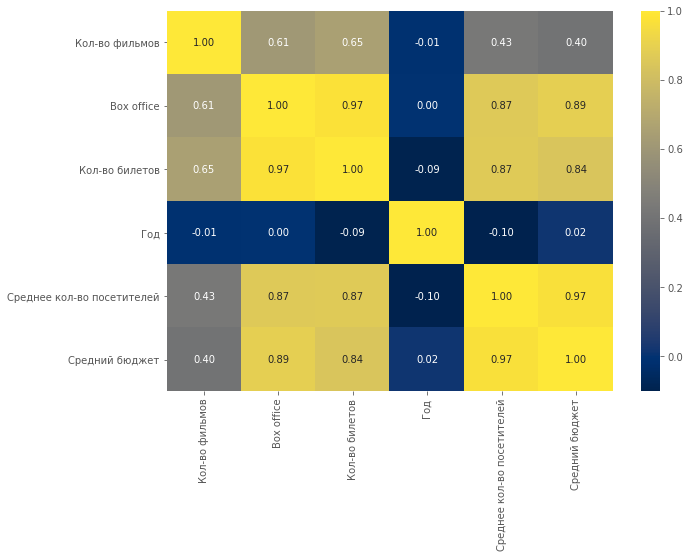

In [122]:
plt.subplots(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='cividis');

Построим график рассеивания между кассовыми сборами и кол-вом билетов

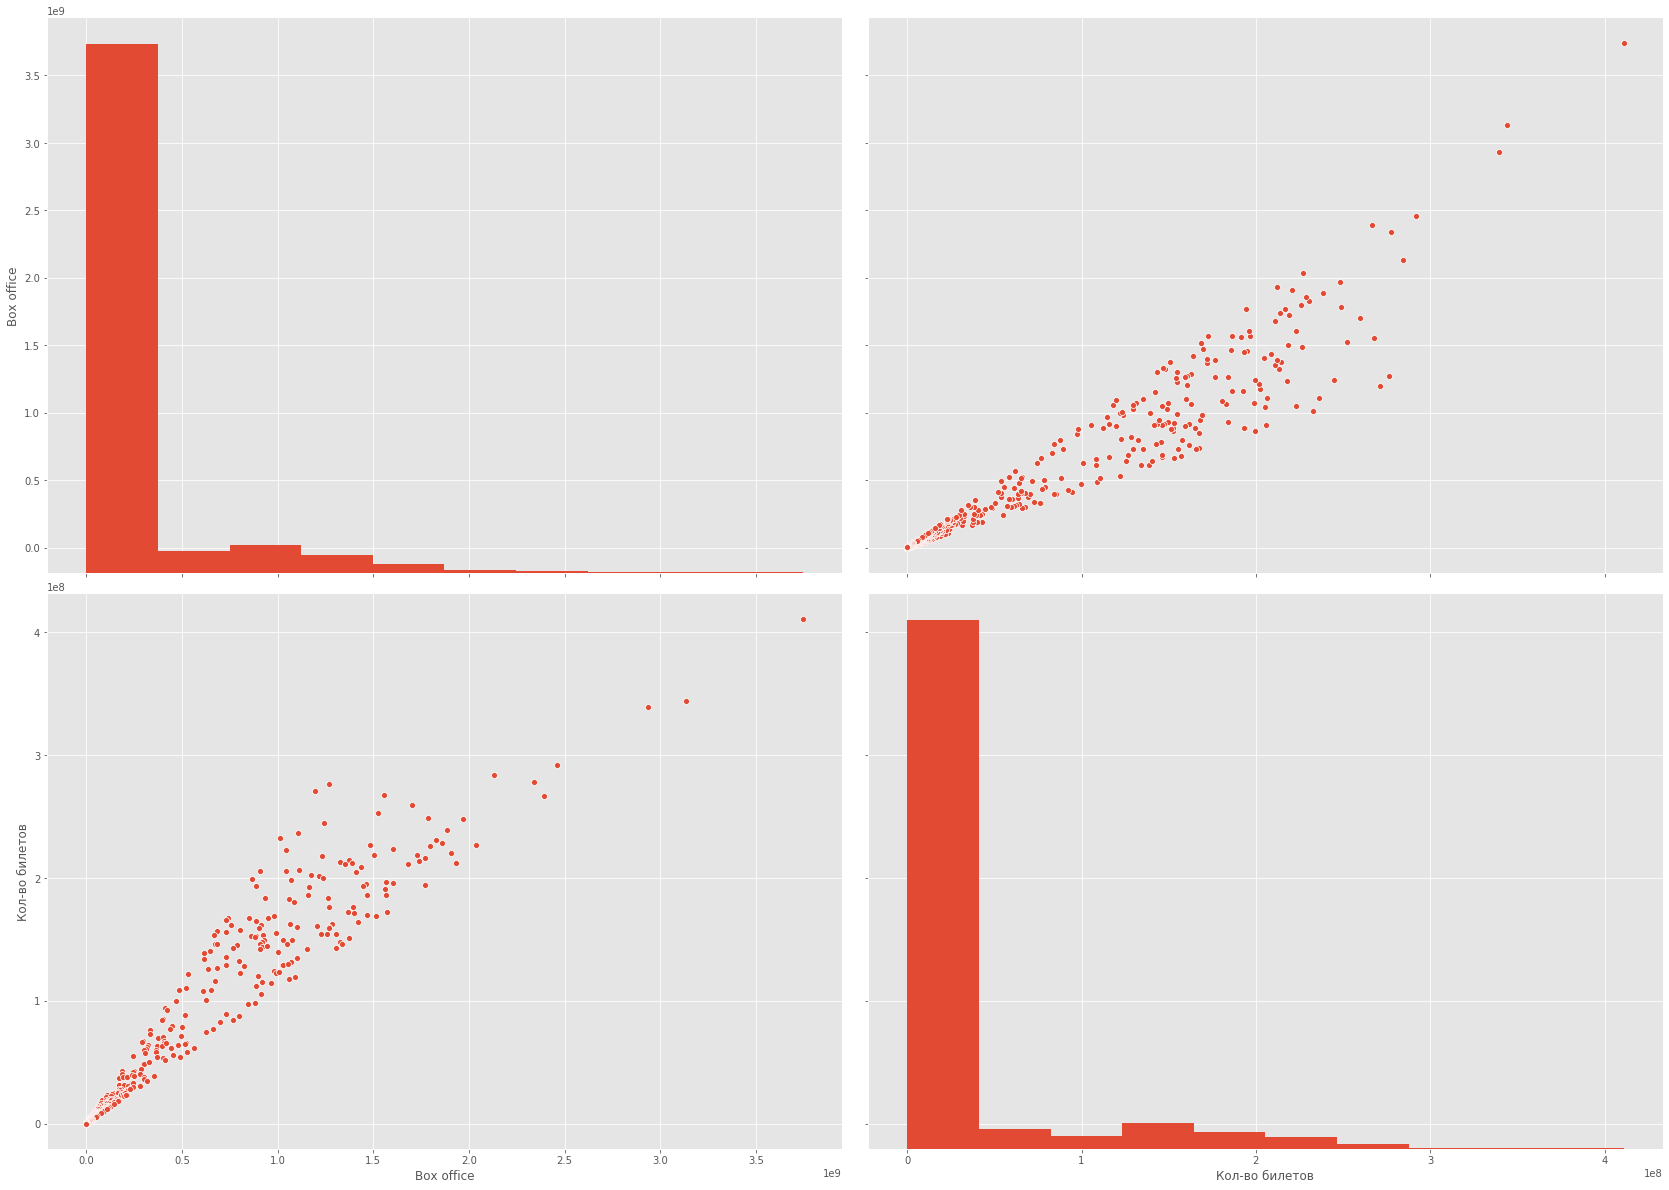

In [123]:
sns_plot = sns.pairplot(df[['Box office', 'Кол-во билетов']], height=8.27, aspect=11.7/8.27)

In [124]:
data = df.groupby('Компания', as_index=False).sum()
data = data.sort_values('Кол-во фильмов', ascending=False)
data

,Компания,Кол-во фильмов,Box office,Кол-во билетов,Год,Среднее кол-во посетителей,Средний бюджет
329,Warner Bros.,795.0,35452249342,5.112650e+09,50175,164199562,1117825079
284,Sony Pictures,718.0,28393618110,4.216652e+09,50175,149662775,1038954887
327,Walt Disney,567.0,39474626801,5.644552e+09,50175,286212428,2150576415
2,20th Century Fox,516.0,25808587001,3.787295e+09,50175,183657878,1242471094
285,Sony Pictures Classics,512.0,1189798137,1.795166e+08,50175,9044646,58640269
...,...,...,...,...,...,...,...
259,Riverrain,1.0,1687000,1.880710e+05,2017,188071,1687000
146,Hombre de Oro,1.0,886410,1.644540e+05,2000,164454,886410
154,Independent Artists,1.0,2793776,5.499550e+05,1999,549955,2793776
155,Independent Indian,1.0,880000,1.017340e+05,2016,101734,880000


In [125]:
data = df.groupby('Компания', as_index=False).sum()
data = data.sort_values('Кол-во фильмов', ascending=False)


fig = px.bar(data[:20],
            x = 'Компания', 
            y='Кол-во фильмов',
            title= 'Количество фильмов разных студий',
            width=1000, height=800)
fig.show()

In [130]:
dff1 = df.loc[df['Компания'] == 'Warner Bros.']
dff2 = df.loc[df['Компания'] == 'Sony Pictures']
dff3 = df.loc[df['Компания'] == 'Walt Disney']
dff4 = df.loc[df['Компания'] == 'Universal']
dff5 = df.loc[df['Компания'] == 'Paramount Pictures	']
dff6 = df.loc[df['Компания'] == '20th Century Fox']
 
res1 = pd.concat([dff1, dff2], ignore_index=True)
res2 = pd.concat([res1, dff3], ignore_index=True)
res3 = pd.concat([res2, dff4], ignore_index=True)
res4 = pd.concat([res3, dff5], ignore_index=True)
res4 = pd.concat([res4, dff6], ignore_index=True)
    
px.scatter(res4, 
        title='Проценты разных компаний в зависимости от года',
        x='Год', 
        y='Процент от общего кол-ва', 
          color = 'Компания')